# First look/Clean Up

* Helpful Links
* [Priority Population/DAC](https://dot.ca.gov/programs/rail-and-mass-transportation/priority-populations-and-disadvantaged-communities)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from siuba import *
from calitp import *
from shared_utils import geography_utils, utils
import difflib
from calitp.storage import get_fs
fs = get_fs()
import os

#Formatting the nb 
pd.options.display.max_columns = 100
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:.2f}".format

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/lctop/"
Caltrans_shape = "https://gis.data.ca.gov/datasets/0144574f750f4ccc88749004aca6eb0c_0.geojson?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
FILE_NAME = "LCTOP_allyears.xlsx"

In [3]:
df1 = to_snakecase(pd.read_excel(f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="LCTOP_Projects"))

## Checking out the raw data

In [4]:
df1.shape

(857, 74)

In [5]:
#Get percentages of how many null values per column
df1.isnull().sum() * 100 / len(df1)

count                                              0.70
#                                                  0.70
funding_year                                       0.70
_d                                                 0.70
distr_                                             0.70
project_id#                                        0.70
lead_agency                                        0.70
project_name                                       0.70
project_type                                       0.58
project_sub_type                                  27.42
project_sub_type_ii                                0.70
#2                                                99.53
project_description__short_                       11.79
project_location                                  28.12
start_date                                        12.02
completion_date                                   27.30
contact_name                                       1.05
contact_phone_#                                 

In [6]:
#Check out that values are what I expect for certain columns
value_count_cols = [
    "project_type","lead_agency","distr_", "project_name", "project_id#", "project_sub_type_ii"]

In [7]:
# https://stackoverflow.com/questions/32589829/how-to-get-value-counts-for-multiple-columns-at-once-in-pandas-dataframe
'''
for column in df1[value_count_cols]:
    print("\n" + column)
    print(df1[column].value_counts())
    
''' 

'\nfor column in df1[value_count_cols]:\n    print("\n" + column)\n    print(df1[column].value_counts())\n    \n'

In [8]:
#Find nunique values 
for column in df1[value_count_cols]:
    print("\n" + column)
    print(df1[column].nunique())


project_type
3

lead_agency
213

distr_
12

project_name
714

project_id#
851

project_sub_type_ii
12


### Some of the monetary columns aren't filled - double check 
* Re calculate the percentage cols: lctop % of total project funds 
* Re calc that total project request 993414+9913 equals PUC 99314
    * Yes they do.

In [9]:
monetary_cols = [ 'puc_99313_funds', 'puc_99314_funds',
       'total_project_request_99314_+_99313', 'total_lctop_funds',
       'total_cci_funds', 'total_project_cost',
       'lctop_%_of_total_project_funds']

In [10]:
subset = df1[monetary_cols].fillna(0)

In [11]:
#https://stackoverflow.com/questions/42405572/how-to-compare-two-columns-of-the-same-dataframe
#Compare if PUC 99313 + PUC 99314 equal to total LCTOP Fund
subset['total_project_comp_to_total_LCTOP_funds'] = np.where(subset['total_project_request_99314_+_99313'] == subset['total_lctop_funds'], 
                                           'same','different')

In [12]:
#Comapre if LCTOP equals CCI 
subset['total_lctop_cci'] = np.where(subset['total_lctop_funds'] == subset['total_cci_funds'], 
                                           'same','different')

In [13]:
#Calculate out total_project_request_99314_+_99313 and see if the results equal what was provided to me.
subset['99314_and_99313'] = subset['puc_99313_funds'] + subset['puc_99314_funds']
subset['my_calc_vs_og_cal'] = np.where(subset['99314_and_99313'] == subset['total_project_request_99314_+_99313'], 
                                           'same','different')

In [14]:
#Compare total_project_request_99314_+_99313 with total CCI funds
subset['CCI_99313_99314'] = np.where(subset['total_project_request_99314_+_99313'] == subset['total_cci_funds'], 'same',
                                     'different')

In [15]:
#Find value_counts
value_count_cols_2 = ['total_project_comp_to_total_LCTOP_funds', 'total_lctop_cci', 'my_calc_vs_og_cal', 'CCI_99313_99314'] 
for column in subset[value_count_cols_2]:
    print("\n" + column)
    print(subset[column].value_counts())


total_project_comp_to_total_LCTOP_funds
different    435
same         422
Name: total_project_comp_to_total_LCTOP_funds, dtype: int64

total_lctop_cci
same         813
different     44
Name: total_lctop_cci, dtype: int64

my_calc_vs_og_cal
same         856
different      1
Name: my_calc_vs_og_cal, dtype: int64

CCI_99313_99314
different    446
same         411
Name: CCI_99313_99314, dtype: int64


In [16]:
#subset.loc[subset['my_calc_vs_og_cal'] == 'different'] 

## Clean Up
* Make sure columns are the right data type
* Find which col represents allocated amounts


### Drop rows with a ton of N/As

In [17]:

df2 = df1.dropna(subset=['lead_agency', 'project_id#','project_name', 'distr_'])

In [18]:
f'The original dataframe is {len(df1)}  rows long but after dropping some rows with missing values, the dataframe is {len(df2)} rows long.'

'The original dataframe is 857  rows long but after dropping some rows with missing values, the dataframe is 851 rows long.'

In [20]:
f"There are {df2['project_id#'].nunique()} unique project IDS"

'There are 851 unique project IDS'

### Change Agency Names
* Some agencies have multiple spellings of its name, clean it up

In [21]:
#Many of the same agencies are spelled slightly different ways 
#Rewrite later 
#https://stackoverflow.com/questions/24554723/str-replace-for-multiple-value-replacement
df2['lead_agency'] = (df2['lead_agency']
                      .str.split("(")
                      .str[0]
                      .str.replace('[^A-Za-z\s]+', '')
                      .str.replace("Publlic","Public")
                      .str.replace("Regional Transit Authority","")
                      .str.replace("Agency","")
                      .str.replace("Commision","Commission")
                      .str.replace("Division","")
                      .str.split(",")
                      .str[0]
                      .str.strip()
                     )

/tmp/ipykernel_1219/3075006119.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
/tmp/ipykernel_1219/3075006119.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
df2["lead_agency"] = df2["lead_agency"].replace(
    {
        'Stanislaus County Public Works   Transit': 'Stanislaus County Public Works Transit',
        'Stanislaus County Public Works  Transit':  'Stanislaus County Public Works Transit',
        'Stanislaus County Public WorksTransit':  'Stanislaus County Public Works Transit',
        'Victor ValleyTransit Authority': 'Victor Valley Transit Authority',
        'YubaSutter Transit Authority':'Yuba Sutter Transit Authority',
        'YubaSutter Transit':'Yuba Sutter Transit Authority',
        'Plumas County Transportation  Commission': 'Plumas County Transportation  Commission',
        'Modoc Transportation':'Modoc County Transportation Commission',
         'Los Angeles County Metoropolitan Transportation Authority': 'Los Angeles County Metropolitan Transportation Authority',
        'Calaveras Transit': 'Calaveras Transit Agnecy',
    }
)

/tmp/ipykernel_1219/231900255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:

df2['lead_agency'].nunique()

181

In [24]:
#df2['lead_agency'].sort_values().unique()

### Change additional values
* Some values are spelled YES/yes/no/No etc so lower all the characters

In [25]:
boolean_cols = ['agency_service_area_has_a_dac',
              'does_project_benefit_an_ab_1550_dac',
              'status',
              'qualifying_1_2_mile_low_income_buffer_',
               'ab_1550_low_income_community__household',
              'does_project_benefit_an_ab_1550_dac',]

In [26]:
for i in boolean_cols:
    df2[i] = (df2[i]
               .str.strip()
               .str.lower()
               .str.replace('close','closed')
               .str.replace('closedd','closed')
                        )

/tmp/ipykernel_1219/775691532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Change Counties 

In [27]:
df2['county'] = df2['county'].str.replace('County','')


/tmp/ipykernel_1219/3541952537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Change data types

In [28]:
#Drop some columns especially those with a very low percentage of populated values 
df2 = df2.drop(columns = ['count', '#','column3',
       'column4', 'column5','other_state_policies,_plans,_or_initiatives',
       'describe_policies,_plans,_or_initiatives','#2','_d','contact_name','contact_phone_#','contact_e_mail',
       'authorized_agent_name','authorized_agent_title','project_description__short_','project_sub_type'])

In [29]:
#Coerce date-time columns to the correct type
date_columns = ['qm_tool__date_', 'completion_date','start_date']

for c in date_columns:
    df2[c] = df2[c].apply(pd.to_datetime, errors='coerce')
    

In [30]:
missing_date = pd.to_datetime('2100-01-01')
for i in date_columns:
    df2[i] = (df2[i]
            .fillna(missing_date)
            .apply(pd.to_datetime)
                    )

In [31]:
#Coerce columns from object to flat
float_columns = ['ridership_increase','fossil_fuel_use_reduction__transportation_']

for c in float_columns:
    df2[c] = df2[c].apply(pd.to_numeric, errors = 'coerce')
    

In [32]:
df2 = df2.fillna(df2.dtypes.replace({'float64': 0.0, 'object': 'None'}))

### Check negative values

In [33]:
env_cols = ['vmt_reduction',
       'ghg_reduction__mtco2e_', 
       'diesel_pm_reductions__lbs_', 'nox_reductions__lbs_',
       'pm_2_5_reductions__lbs_', 'reactive_organic_gas_reduction__lbs_',
       'fossil_fuel_use_reduction__transportation_',
       'fossil_fuel_use_reduction__energy_',
       'renewable_energy_generation__kwh_',]

In [34]:
subset_env = df2[env_cols]

In [35]:
subset_env.lt(0).sum()

vmt_reduction                                  0
ghg_reduction__mtco2e_                         0
diesel_pm_reductions__lbs_                    17
nox_reductions__lbs_                          54
pm_2_5_reductions__lbs_                       19
reactive_organic_gas_reduction__lbs_          11
fossil_fuel_use_reduction__transportation_     9
fossil_fuel_use_reduction__energy_            43
renewable_energy_generation__kwh_              0
dtype: int64

In [36]:
#Find nunique values 
for column in df2[value_count_cols]:
    print("\n" + column)
    print(df2[column].nunique())


project_type
2

lead_agency
181

distr_
12

project_name
714

project_id#
851

project_sub_type_ii
12


### Save it

In [37]:
'''
with pd.ExcelWriter(f"{GCS_FILE_PATH}LCTOP_cleaned.xlsx") as writer:
    df2.to_excel(writer, sheet_name="cleaned", index=False)
 '''

'\nwith pd.ExcelWriter(f"{GCS_FILE_PATH}LCTOP_cleaned.xlsx") as writer:\n    df2.to_excel(writer, sheet_name="cleaned", index=False)\n '

## Initial insights

### [Disadvantaged Communities](https://dot.ca.gov/programs/rail-and-mass-transportation/priority-populations-and-disadvantaged-communities)
* Most projects benefit DAC.
* Most agencies have a service area with DAC.

In [38]:
#count 
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html
result = {}
for i in df2[boolean_cols]:
    result[i] = (df2[i].value_counts()) 

In [39]:
result_df = (pd.DataFrame.from_dict(result)
             .fillna(0)
             .rename(columns =
                     {'index':'Boolean Values'})
            )

result_df = result_df.div(result_df.sum(axis=0), axis=1)
        

In [40]:
result_df.round(2).style.background_gradient()

,agency_service_area_has_a_dac,does_project_benefit_an_ab_1550_dac,status,qualifying_1_2_mile_low_income_buffer_,ab_1550_low_income_community__household
0,0.000000,0.000000,0.000000,0.180000,0.000000
1,0.000000,0.000000,0.000000,0.190000,0.000000
None,0.000000,0.000000,0.370000,0.480000,0.410000
closed,0.000000,0.000000,0.020000,0.000000,0.000000
no,0.300000,0.340000,0.000000,0.150000,0.050000
open,0.000000,0.000000,0.610000,0.000000,0.000000
yes,0.700000,0.660000,0.000000,0.000000,0.540000


### Summary Tables

In [41]:
#Clean column titles
def cols_cleanup(df):
    df.columns = (df.columns
                  .str.replace('[_]', ' ')
                  .str.title()
                  .str.strip()
                 )
    return df

In [42]:
sum_cols = ['funds_to_benefit_dac','total_project_request_99314_+_99313', 'total_project_cost','vmt_reduction',
       'ghg_reduction__mtco2e_', 
       'diesel_pm_reductions__lbs_', 'nox_reductions__lbs_',
       'pm_2_5_reductions__lbs_', 'reactive_organic_gas_reduction__lbs_',
       'fossil_fuel_use_reduction__transportation_','ridership_increase',
       'fossil_fuel_use_reduction__energy_', 'renewable_energy_generation__kwh_']
nunique_cols = ['project_id#', 'lead_agency']

In [43]:
funding_year_summary = geography_utils.aggregate_by_geography(
    df2, 
    group_cols=['funding_year'],
    nunique_cols = nunique_cols,
    sum_cols = sum_cols)

funding_year_summary = (cols_cleanup(funding_year_summary)
                        .sort_values('Funding Year')
                        .rename(columns = {'Lead Agency':'# of Agencies',
                                           'Project Id#': '# of Projects'})
                                           )

/tmp/ipykernel_1219/3875248575.py:4: FutureWarning: The default value of regex will change from True to False in a future version.


In [44]:
funding_year_summary

,Funding Year,Diesel Pm Reductions Lbs,Fossil Fuel Use Reduction Energy,Fossil Fuel Use Reduction Transportation,Funds To Benefit Dac,Ghg Reduction Mtco2E,Nox Reductions Lbs,Pm 2 5 Reductions Lbs,Reactive Organic Gas Reduction Lbs,Renewable Energy Generation Kwh,Ridership Increase,Total Project Cost,Total Project Request 99314 + 99313,Vmt Reduction,# of Agencies,# of Projects
0,14-15,0.00,0.00,0.00,22753617.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,24165593.00,0.00,83,95
1,15-16,0.00,0.00,0.00,69453304.00,10734.81,0.00,0.00,0.00,0.00,236838.00,532800958.42,74700760.00,1193035.95,107,132
2,16-17,0.00,0.00,0.00,29652105.00,4161658.31,0.00,0.00,0.00,0.00,726533623.50,2625839228.00,34539105.00,10181040666.00,105,126
3,17-18,72745.82,3110295.00,0.00,66033836.71,3615714.54,17961394.95,607338.50,1143040.39,0.00,1728538312.51,2526653147.52,96864564.50,7682500431.24,109,152
4,18-19,343172.65,0.00,74167587.23,91638903.30,3062602.71,11417960.94,469422.60,1476528.45,0.00,709833819.75,4137512637.19,146949406.00,4593429702.34,120,180
5,19-20,1428119.23,-576698452.72,86239774.74,79344810.00,2431934.00,11556745.30,1408618.81,4032264.90,3360000.00,205879775.19,2889873923.16,146054354.00,3096126163.97,110,166


In [45]:
district_summary = geography_utils.aggregate_by_geography(
    df2, 
    group_cols= ['distr_'],
    nunique_cols = nunique_cols,
    sum_cols = sum_cols,)
district_summary = (cols_cleanup(district_summary)
                        .sort_values('Distr')
                        .rename(columns = {'Lead Agency':'# of Agencies',
                                           'Project Id#': '# of Projects'})
                                           )
district_summary

/tmp/ipykernel_1219/3875248575.py:4: FutureWarning: The default value of regex will change from True to False in a future version.


,Distr,Diesel Pm Reductions Lbs,Fossil Fuel Use Reduction Energy,Fossil Fuel Use Reduction Transportation,Funds To Benefit Dac,Ghg Reduction Mtco2E,Nox Reductions Lbs,Pm 2 5 Reductions Lbs,Reactive Organic Gas Reduction Lbs,Renewable Energy Generation Kwh,Ridership Increase,Total Project Cost,Total Project Request 99314 + 99313,Vmt Reduction,# of Agencies,# of Projects
0,1.00,103.36,-141055.15,70484.00,0.00,18488.67,1301.34,47.65,225.51,0.00,753107.00,4180995.00,2301045.00,15128514.51,7,32
1,2.00,139.31,-258294.70,103247.40,97165.50,3280.63,2732.16,60.49,295.87,0.00,251690.00,3951858.00,2403382.00,3959178.92,10,37
2,3.00,844.58,-12565575.56,2646770.76,13721967.00,92223.21,271577.44,2916.76,18180.12,0.00,19075842.00,92313849.71,24354724.00,88488520.52,27,138
3,4.00,1819284.32,-456283278.93,131625537.61,129089347.20,12397941.69,38003101.51,2408985.14,6513817.31,0.00,3164125991.04,11424595473.00,191992875.00,23359678150.08,29,155
4,5.00,7601.57,-6142167.96,1569921.26,6678624.50,46010.35,294845.01,7229.38,13245.50,3360000.00,5592813.42,41062474.00,13469015.00,23483066.77,13,68
5,6.00,612.94,-2333163.16,839596.56,15737590.76,36642.95,17759.43,411.95,1649.78,0.00,4392314.21,51279701.74,19597846.00,41941021.10,31,126
6,7.00,4088.65,-76712805.83,14436420.95,121804166.20,329208.21,372677.41,7514.35,39588.94,0.00,50162987.75,409086897.76,164605685.00,370945504.51,21,95
7,8.00,2289.36,-5313608.14,4523462.18,23838154.85,110781.08,1576223.73,48751.96,32425.84,0.00,73950573.53,299223477.92,33023402.00,1087298714.26,12,82
8,9.00,21.53,-61553.50,11903.34,0.00,444.14,277.04,24.34,86.55,0.00,20604.00,935496.00,362380.00,386370.79,4,15
9,10.00,7528.09,-139669.98,413605.66,9849847.00,82335.34,156497.16,6160.99,11867.28,0.00,6701268.50,30664161.16,13235978.50,234371667.56,24,64


In [46]:
project_type_summary = geography_utils.aggregate_by_geography(
    df2, 
    group_cols= ['project_sub_type_ii'],
    nunique_cols = nunique_cols,
    sum_cols = sum_cols,)

project_type_summary = (cols_cleanup(project_type_summary)
                        .sort_values('Lead Agency')
                        .rename(columns = {'Lead Agency':'# of Agencies',
                                           'Project Id#': '# of Projects'})
                                           )
project_type_summary

/tmp/ipykernel_1219/3875248575.py:4: FutureWarning: The default value of regex will change from True to False in a future version.


,Project Sub Type Ii,Diesel Pm Reductions Lbs,Fossil Fuel Use Reduction Energy,Fossil Fuel Use Reduction Transportation,Funds To Benefit Dac,Ghg Reduction Mtco2E,Nox Reductions Lbs,Pm 2 5 Reductions Lbs,Reactive Organic Gas Reduction Lbs,Renewable Energy Generation Kwh,Ridership Increase,Total Project Cost,Total Project Request 99314 + 99313,Vmt Reduction,# of Agencies,# of Projects
11,Vehicles upgrades to support new expanded/enhanced transit service,859.88,0.00,826647.11,1571622.00,12803.34,37990.82,586.47,2126.01,0.00,750533.00,3504000.00,3143244.00,21802983.65,1,1
9,Alternative transportation services,19.89,0.00,0.00,100526.00,1110.97,331.60,9.99,66.17,0.00,360170.00,256174.74,90977.00,3224984.00,2,2
10,New Transit related amenities,3.25,0.00,0.00,0.00,60.87,37.57,3.00,8.02,0.00,43432.50,357764.00,126065.00,140883.79,3,3
7,Renewable energy/fuel for transit service,0.00,0.00,23415.71,826620.00,13800.06,750825.94,2830.66,21082.87,0.00,29392.00,3469886.00,2040465.00,12271180.00,9,9
5,Infrastructure to support new expanded/enhanced transit service,10890.61,-9878941.98,21844147.90,14348902.00,1301255.19,134260.97,5069.71,27306.69,3360000.00,658532776.50,564914743.00,19488007.00,4269784558.71,10,16
3,Network/fare integration,141.43,0.00,1353.83,9931075.00,2030247.88,1067.91,22.30,228.45,0.00,631382424.90,85352573.00,11422334.00,5496118120.35,12,24
6,New vehicles for new expanded/enhanced transit service,486037.70,-8125021.57,16371837.41,13733702.20,363567.19,7026295.15,445024.89,1116212.43,0.00,46558509.55,441429147.00,16491919.50,774848041.60,19,29
4,Infrastructure to support zero-emission vehicle(s),1265107.83,-452383553.46,65896062.88,26065848.50,2249649.01,10881736.22,1241590.99,4046528.51,0.00,138530447.00,2067255898.00,49612423.00,2570415354.34,25,34
8,New zero-emission vehicles,22940.69,-43045091.03,34751922.33,60061316.16,4743018.64,21518762.42,759207.72,1309086.95,0.00,1019841443.35,6497621200.98,102732493.00,5189093150.28,58,123
2,New transit related amenities,50872.82,-59379516.69,8282129.82,30748117.20,2247707.23,604755.18,24038.63,115757.76,0.00,814799070.94,2401306189.00,42217131.00,6389424102.78,66,141


### Maps

In [47]:
geojson = (gpd.read_file(f'{Caltrans_shape}')
               .to_crs(epsg=4326))
#Keep only the columns of interest 
geojson = geojson[["DISTRICT", "Shape_Length", "Shape_Area", "geometry"]]

In [48]:
#Merge geojson with the summarized df
gdf1 = geojson.merge(
    district_summary, how="inner", left_on="DISTRICT", right_on="Distr") 
  

(-124.92362879654993,
 -113.61729836444997,
 32.06046296725004,
 42.48325525375008)

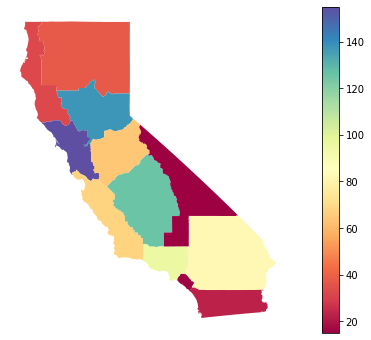

In [84]:
(gdf1.plot(figsize=(12, 6), cmap='Spectral', column="# of Projects", legend=True).axis("off"))

(-124.92362879654993,
 -113.61729836444997,
 32.06046296725004,
 42.48325525375008)

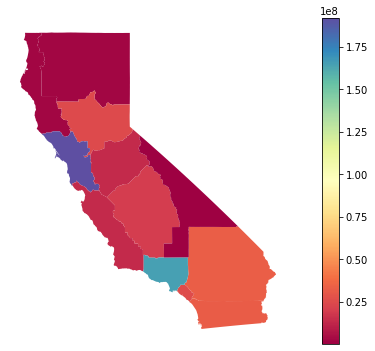

In [83]:
(gdf1
 .plot(figsize=(12, 6), cmap='Spectral', column="Total Project Request 99314 + 99313", legend=True)
 .axis("off")
)

In [51]:
# save to GCS
def geojson_gcs_export(gdf, GCS_FILE_PATH, FILE_NAME):
    """
    Save geodataframe as parquet locally,
    then move to GCS bucket and delete local file.

    gdf: geopandas.GeoDataFrame
    GCS_FILE_PATH: str. Ex: gs://calitp-analytics-data/data-analyses/my-folder/
    FILE_NAME: str. Filename.
    """
    gdf.to_file(f"./{FILE_NAME}.geojson", driver="GeoJSON")
    fs.put(f"./{FILE_NAME}.geojson", f"{GCS_FILE_PATH}{FILE_NAME}.geojson")
    os.remove(f"./{FILE_NAME}.geojson")

In [52]:
'''
# call the function
geojson_gcs_export(
    gdf1,
    "gs://calitp-analytics-data/data-analyses/lctop/",
    "lctop_geojson",
)
'''

'\n# call the function\ngeojson_gcs_export(\n    gdf1,\n    "gs://calitp-analytics-data/data-analyses/lctop/",\n    "lctop_geojson",\n)\n'

## Lat Lon

In [53]:
#Get only values w/ lon and lat
df3 = (df2.loc[df2["project_location"] != 'None'])

In [55]:
df3['project_location_2'] = (df1['project_location']
                             .str.split(";").str[0])

/tmp/ipykernel_1219/1287530581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
df3[['lon', 'lat']] = (df3['project_location_2']
                       .str.split(',', 1, expand=True)
                       .apply(pd.to_numeric, errors = 'coerce')
                       .fillna(0)
                      ) 

/tmp/ipykernel_1219/1896286892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1219/1896286892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [57]:
df3 = (df3[(df3['lon'] != 0) & (df3['lat'] != 0)])
len(df3)

In [61]:
gdf2 = geography_utils.create_point_geometry(df3, 'lon','lat')

In [90]:
cols_to_keep = ['funding_year', 'distr_', 'project_id#', 'lead_agency', 'project_name',
       'project_type', 'project_sub_type_ii', 'start_date', 'completion_date',
        'puc_99313_funds','puc_99314_funds', 'total_project_request_99314_+_99313',
       'total_lctop_funds', 'total_cci_funds', 'total_project_cost',
       'lctop_%_of_total_project_funds', 'agency_service_area_has_a_dac', 'does_project_benefit_an_ab_1550_dac',
        'status', 'lon', 'lat',
       'geometry']

In [91]:
gdf2 = gdf2[cols_to_keep]

In [104]:
type(gdf2)

geopandas.geodataframe.GeoDataFrame

In [108]:
'''
geojson_gcs_export(
    gdf2,
    "gs://calitp-analytics-data/data-analyses/lctop/",
    "lctop_geojson2")
    '''

/opt/conda/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
